<font color="blue">Привет. Извиняюсь за задержку, небольшие накладки. Давай разбираться как управлять временем

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
path = Path.cwd()

In [4]:
df = pd.read_csv('{}/datasets/taxi.csv'.format(path), index_col='datetime', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  26496 non-null  int64
 1   num_orders  26496 non-null  int64
dtypes: int64(2)
memory usage: 621.0 KB


In [9]:
df.head()

,Unnamed: 0,num_orders
datetime,,
2018-03-01 00:00:00,0,9
2018-03-01 00:10:00,1,14
2018-03-01 00:20:00,2,28
2018-03-01 00:30:00,3,20
2018-03-01 00:40:00,4,32


In [10]:
df.index.is_monotonic

True

In [11]:
df.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fa1af10>,
      dtype=object)

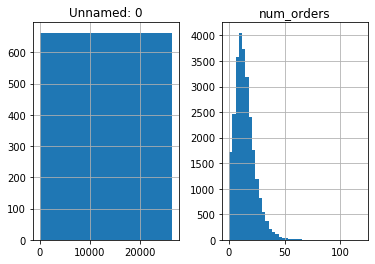

In [12]:
df.hist(bins=40)

Данные в полном порядке. Пропусков нет, уже отсортированы

<font color="blue">Отлично

# 2. Анализ

In [43]:
df = pd.read_csv('{}/datasets/taxi.csv'.format(path), index_col='datetime', parse_dates=True, usecols=['num_orders', 'datetime'])
print(df)
df = df.resample('1H').sum()

# df['rolling_mean_day'] = df.rolling(24).mean()
# df.plot()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]


Видно что кол-во заказов ростет. Посмотрим что с сезонностью

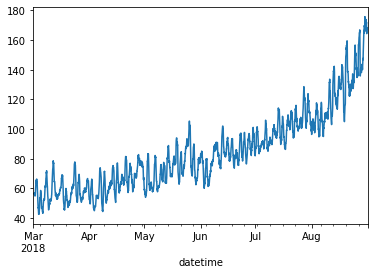

In [45]:
df = pd.read_csv('{}/datasets/taxi.csv'.format(path), index_col='datetime', parse_dates=True, usecols=['num_orders', 'datetime'])
df = df.resample('1H').sum()
decomposed = seasonal_decompose(df)

decomposed.trend.plot()


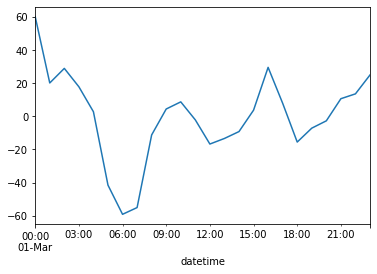

In [46]:
decomposed.seasonal['2018-03-01': '2018-03-01'].plot()

In [47]:
print('Среднее кол-во заказов по выборке: {:.2f}'.format(df['num_orders'].mean()))

Среднее кол-во заказов по выборке: 84.42


Тренд точно восходящий. Теперь ещё видны и часы пиковой нагрузки: с 22 до 3 утра, 9 утра и 17 дня. Меньше всего заказов с 3 до 7 утра. Можно предположить, что на спрос влияют два фактора: кол-во рейсов и доступность альтернативных способов транспорта(аэроэкспресс)

<font color="blue">Хорошо

# 3. Обучение

In [48]:
def preparing():
    df = pd.read_csv('{}/datasets/taxi.csv'.format(path), index_col='datetime', parse_dates=True, usecols=['num_orders', 'datetime'])
    df = df.resample('1H').sum()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    return df

def add_lag_values(df, lag_list):
    for lag in lag_list:
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    return df    

Добавим признаков в датасет

In [49]:
df = preparing()
df = add_lag_values(df, range(1, 24, 1))
df = df.dropna()
df.head()

,num_orders,month,day,dayofweek,dayofyear,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 23:00:00,58,3,1,3,60,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 00:00:00,90,3,2,4,61,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 01:00:00,120,3,2,4,61,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 02:00:00,75,3,2,4,61,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 03:00:00,64,3,2,4,61,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


Разделим данные на тренировочные и тестовые

In [50]:
df = preparing()
df = add_lag_values(df, range(1, 48, 1))
df = df.dropna()
features = df.drop(columns='num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.111, shuffle=False)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(3495, 51)
(437, 51)
(437, 51)


Модель LinearRegression

In [51]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_predictions = lr.predict(features_valid)

print('RMSE для линейной модели: {:.2f}'.format(mean_squared_error(target_valid, lr_predictions)**0.5))

RMSE для линейной модели: 33.34


Модель DT

In [52]:
for max_depth in range(1, 10):    
    dtr = DecisionTreeRegressor(max_depth=max_depth)
    dtr.fit(features_train, target_train)
    dtr_predictions = dtr.predict(features_valid)
    print('max_depth = {}, RMSE: {:.2f}'.format(max_depth, mean_squared_error(target_valid, dtr_predictions)**0.5))

max_depth = 1, RMSE: 51.06
max_depth = 2, RMSE: 45.64
max_depth = 3, RMSE: 42.53
max_depth = 4, RMSE: 42.54
max_depth = 5, RMSE: 41.20
max_depth = 6, RMSE: 39.36
max_depth = 7, RMSE: 39.90
max_depth = 8, RMSE: 39.97
max_depth = 9, RMSE: 42.41


Модель RF

In [53]:
for n_estimators in range(1, 50, 10):    
    rfr = RandomForestRegressor(n_estimators=n_estimators)
    rfr.fit(features_train, target_train)
    rfr_predictions = rfr.predict(features_valid)
    print('n_estimators = {}, RMSE: {:.2f}'.format(n_estimators, mean_squared_error(target_valid, rfr_predictions)**0.5))
    

n_estimators = 1, RMSE: 44.39
n_estimators = 11, RMSE: 33.99
n_estimators = 21, RMSE: 33.74
n_estimators = 31, RMSE: 33.42
n_estimators = 41, RMSE: 32.50


Линейная модель, неожиданно, оказалась самой точной. Да и выполняется быстро!<br>
До этого мы создавали фичи(lag) за последние 48 часов с шагом в час. Но как мы видели выше у нас есть сильная зависимость спроса от времени суток. Создадим фичи только из данных с лагом в 24 часа

In [54]:
df = preparing()
df = add_lag_values(df, range(24, 240, 24))
df = df.dropna()
features = df.drop(columns='num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.111, shuffle=False)

lr = LinearRegression()
lr.fit(features_train, target_train)
lr_predictions = lr.predict(features_valid)

print('RMSE для линейной модели: {:.2f}'.format(mean_squared_error(target_valid, lr_predictions)**0.5))

RMSE для линейной модели: 29.78


Получилось лучше чем в первый раз!

# 4. Тестирование

In [55]:
df = preparing()
df = add_lag_values(df, range(24, 240, 24))
df = df.dropna()
features = df.drop(columns='num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

lr = LinearRegression()
lr.fit(features_train, target_train)
lr_predictions = lr.predict(features_test)

print('RMSE для линейной модели: {:.2f}'.format(mean_squared_error(target_test, lr_predictions)**0.5))


RMSE для линейной модели: 34.93


#### Вывод
1. Из трех моделей лучше всего справляется линейная, видимо, из-за линейной природы времени
2. Создание фич с учетом периодичности дает лучший результат при меньшем общем кол-ве фичей

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

<font color="blue">Добротная работа. Я если честно, после вашего знакомства с бустингом думал что будет только он. Но хорошо что классику используешь. В качестве факультатива предлагаю посмотреть какая метрика будет при использовании бустинга. Зачтено

## Посмотрим бустинг!

In [56]:
import lightgbm as lgb
# Обучение LightGBM модели
def lgb_model_train(features_train, target_train, params):
    d_train = lgb.Dataset(features_train, label=target_train)
    clf = lgb.train(params, d_train, 100)
    return clf

OSError: dlopen(/usr/local/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /usr/local/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [57]:
df = preparing()
df = add_lag_values(df, range(24, 240, 24))
df = df.dropna()
features = df.drop(columns='num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.111, shuffle=False)


params = {}
for num_leaves in [5, 10, 20, 30]:
    for min_data_in_leaf in [5, 10, 20, 30, 50, 80]:
        params['num_leaves'] = num_leaves
        params['min_data_in_leaf'] = min_data_in_leaf
        lgb_model = lgb_model_train(features_train, target_train, params)
        predictions = lgb_model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions)**0.5
        print('LightGBM с num_leaves = {}, min_data_in_leaf = {}: RMSE = {:.2f}'.format(num_leaves, min_data_in_leaf, rmse))

NameError: name 'lgb_model_train' is not defined

с LightGBM лучший показатель для num_leaves = 5, min_data_in_leaf = 5. Попробуем на тесте

In [ ]:
df = preparing()
df = add_lag_values(df, range(24, 240, 24))
df = df.dropna()
features = df.drop(columns='num_orders')
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

params['num_leaves'] = 5
params['min_data_in_leaf'] = 5
lgb_model = lgb_model_train(features_train, target_train, params)
predictions = lgb_model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('LightGBM с num_leaves = {}, min_data_in_leaf = {}: RMSE = {:.2f}'.format(num_leaves, min_data_in_leaf, rmse))

<b>На валидационной выборке LightGBM оказалась чуть лучше линейной модели. Но на тесте LightGBM уже проиграла 34.93 против 38.51. Получается что если бы я включил в исходный список моделей LightGBM я бы получил результат хуже:( Интересно, можно от этого подстраховаться?</b>